# Running multiple classification models for the RuBisCO combined dataset 
## Binary activity defined by bimodal distribution (for large dataset) & inactive_mutant as reference (for mutant datasets)

In [328]:
import torch
import esm
import pickle
import random
from collections import Counter
from tqdm import tqdm
from datetime import datetime
from Bio import AlignIO, SeqIO
import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay


In [249]:
def read_fasta_to_df(fasta_file, seq_header):   # We are going to ignore/remove all the other info like name and stuff from the fasta, just the id
    df = pd.DataFrame.from_records([item.__dict__ for item in SeqIO.parse(fasta_file, format='fasta')])
    df[seq_header] = df.apply(lambda x: ''.join(x['_seq']), axis=1)
    df = df.drop(columns=['_seq', 'name', 'description', 'dbxrefs', 'annotations', '_per_letter_annotations', 'features'])
    return(df)

In [145]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

def make_tSNE(input_df, embedding_col, id_col, perplexity=30):
    cosine_dist_matrix = pairwise_distances(np.stack(input_df[embedding_col].values), metric="cosine")
    tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=perplexity)
    tsne_out = tsne.fit_transform(cosine_dist_matrix)

    df_tsne = pd.DataFrame(tsne_out, columns=['Dim1', 'Dim2'])
    df_tsne['LSU_SSU_id'] = input_df[id_col].to_list()
    df_tsne = df_tsne.fillna(0)

    df_out = pd.merge(input_df, df_tsne, on=[id_col])

    return(df_out)

## Preparing the data

In [167]:
large_dataset = pd.read_pickle("/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/large_assay_dataset_wco2_wiptg_bimodal_activity_threshold.pkl")
large_dataset = large_dataset[["LSU_id", "SSU_id", "lsu_seq", "ssu_seq", "activity_binary"]]

mutant_dataset = pd.read_pickle("/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/form_III_IB_anc_variants_binary_activity_only_wrt_inactive_variant.pkl")
mutant_dataset.rename(columns={"activity_binary_wrt_inactive_Anc": "activity_binary"}, inplace=True)

combined_dataset = pd.concat([large_dataset, mutant_dataset], ignore_index=True)
combined_dataset = combined_dataset[combined_dataset['LSU_id'] != "SUMO"]
combined_dataset = combined_dataset[combined_dataset['LSU_id'] != "DEAD"]

In [168]:
combined_dataset['LSU_SSU_id'] = combined_dataset.apply(lambda x: x['LSU_id'] + "-" + x['SSU_id'] if pd.notna(x['SSU_id']) else x['LSU_id'] + "-none", axis=1)
combined_dataset['LSU_SSU_seq'] = combined_dataset.apply(lambda x: x['lsu_seq'] + x['ssu_seq'] if pd.notna(x['ssu_seq']) else x['lsu_seq'], axis=1)

## Building embeddings

In [169]:
pretrained_arg = esm.pretrained.esm2_t33_650M_UR50D() ## For ESM-1b: `esm1_t34_670M_UR50S`; ESM-2: `esm2_t33_650M_UR50D()`
layers = 33 ## For ESM-1b: 34; ESM-2: 33

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()
model = model.to(torch.device('cuda:0'))

def compute_embedding(key, value):
    inp = [(key, value)]
    batch_labels, batch_strs, batch_tokens = batch_converter(inp)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(torch.device('cuda:0'))
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[layers])
        
    token_representations = results["representations"][layers]
    # return token_representations[0, 0]
    return token_representations[0, 1 : batch_lens[0] - 1].mean(0)


combined_dataset['lsu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['LSU_id'], x['lsu_seq']).cpu().numpy() if pd.notna(x['lsu_seq']) else np.nan, axis=1)
combined_dataset['ssu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['SSU_id'], x['ssu_seq']).cpu().numpy() if pd.notna(x['ssu_seq']) else np.nan, axis=1)
combined_dataset['lsussu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['LSU_SSU_id'], x['LSU_SSU_seq']).cpu().numpy() if pd.notna(x['LSU_SSU_seq']) else np.nan, axis=1)

In [170]:
## Generating a weighted average of the LSU and SSU embeddings -- weighted based on the length of the LSU & SSU sequence

combined_dataset['lsu_ssu_weighted_esm'] = combined_dataset.apply(lambda x: np.average((x['lsu_esm'], x['ssu_esm']), axis=0, weights=[
    float(len(x['lsu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq'])), float(len(x['ssu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq']))
    ]) 
    if pd.notna(x['ssu_seq']) else x['lsu_esm'], axis=1)

#### Removing the duplicate entries that are the Anc365, Anc366, Anc367, Anc393 & Anc509 entries from the combined dataset

In [171]:
repeat_entries = ["Anc365", "Anc366", "Anc367", "Anc393", "Anc509"]
combined_dataset = combined_dataset[~combined_dataset['LSU_id'].isin(repeat_entries)]

In [322]:
def write_df_to_fasta(df, output_file, id, seq_column):
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            f.write(f">{row[id]}\n{row[seq_column]}\n")

write_df_to_fasta(combined_dataset, "/home/kaustubh/RuBisCO_ML/regressor_models/data/combined_dataset_concatenated_LSU_SSU_seq.fasta", "LSU_SSU_id", "LSU_SSU_seq")

## Preparing the data for training

In [109]:
Xs = []
ys = []
data = []
headers = []

for i, row in combined_dataset.iterrows():
    header = row['LSU_SSU_id']
    headers.append(header)
    sequence = row['LSU_SSU_seq']
    data.append((header, sequence))
    ys.append(row['activity_binary'])
    Xs.append(row['lsu_ssu_weighted_esm'])    ## Change based on what is to be used as a sequence embedding

## Creating Training and Test set

In [110]:
def generate_train_test(Xs, ys, headers, random_seed, fraction=0.8):
    lsu_list = [x.split("-")[0] for x in headers]
    lsu_list_uniq = pd.Series(lsu_list).unique().copy()
    random.seed(random_seed)
    random.shuffle(lsu_list_uniq)
    train_size = int(len(lsu_list_uniq) * fraction)
    train_set = lsu_list_uniq[:train_size]
    test_set = lsu_list_uniq[train_size:]
    train_indices = [i for i, x in enumerate(lsu_list) if x in train_set]
    test_indices = [i for i, x in enumerate(lsu_list) if x in test_set]

    Xs_train = [Xs[i] for i in train_indices]
    Xs_test = [Xs[i] for i in test_indices]
    ys_train = [ys[i] for i in train_indices]
    ys_test = [ys[i] for i in test_indices]
    return train_indices, test_indices, train_set, test_set, Xs_train, Xs_test, ys_train, ys_test

train_indices, test_indices, train_ids, test_ids, Xs_train, Xs_test, ys_train, ys_test = generate_train_test(Xs, ys, headers, 42)

## Training block

In [111]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svc_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfc_grid = {
    'n_estimators' : [100],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [2, 10],
    'min_samples_leaf': [1, 4]
}
lgr_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000],
    'l1_ratio': [0.5]
}

In [170]:
cls_list = [KNeighborsClassifier, SVC, RandomForestClassifier, LogisticRegression]
param_grid_list = [knn_grid, svc_grid, rfc_grid, lgr_grid]
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(),
        param_grid = param_grid,
        scoring = 'accuracy',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 24 candidates, totalling 120 fits
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear

In [173]:
grid_list

[GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [15, 30], 'n_neighbors': [5, 10],
                          'p': [1, 2], 'weights': ['uniform', 'distance']},
              scoring='accuracy', verbose=1),
 GridSearchCV(estimator=SVC(), n_jobs=-1,
              param_grid={'C': [0.1, 1.0, 10.0], 'degree': [3],
                          'gamma': ['scale'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              scoring='accuracy', verbose=1),
 GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 4],
                          'min_samples_split': [2, 10], 'n_estimators': [100]},
              scoring='accuracy', verbose=1),
 GridSearchCV(estimator=Lo

## Testing the trained model 


KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, p=1,
                     weights='distance')


Accuracy: 0.8553370786516854
Confusion Matrix:
 [[208  85]
 [ 18 401]]
ROC AUC: 0.8848224685786897

SVC(C=10.0, kernel='linear')
Accuracy: 0.7640449438202247
Confusion Matrix:
 [[164 129]
 [ 39 380]]

RandomForestClassifier(criterion='log_loss')
Accuracy: 0.8595505617977528
Confusion Matrix:
 [[226  67]
 [ 33 386]]
ROC AUC: 0.891970154846172

LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=1000, penalty=None,
                   solver='saga')
Accuracy: 0.8146067415730337
Confusion Matrix:
 [[174 119]
 [ 13 406]]
ROC AUC: 0.8434595616085757


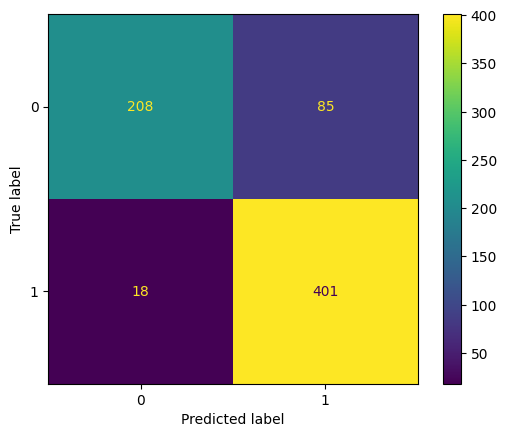

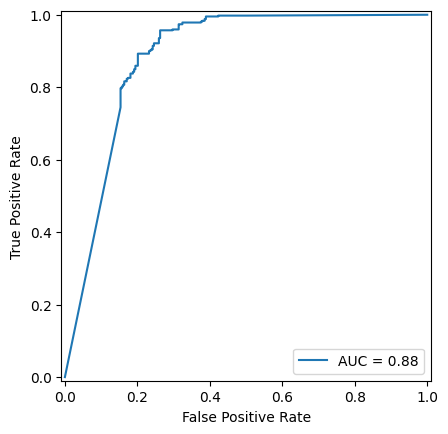

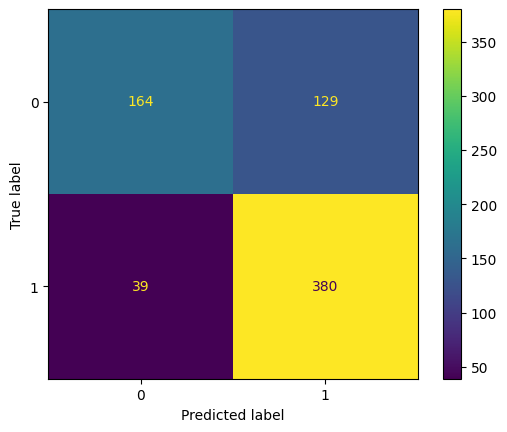

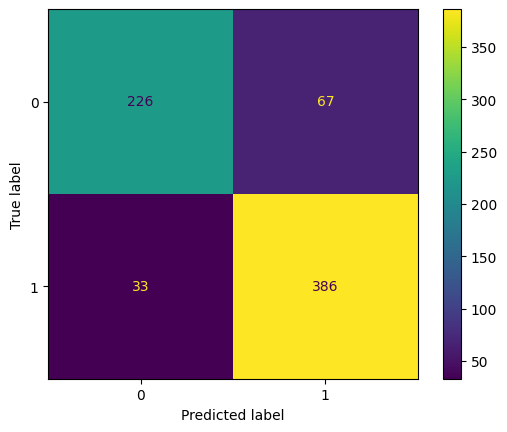

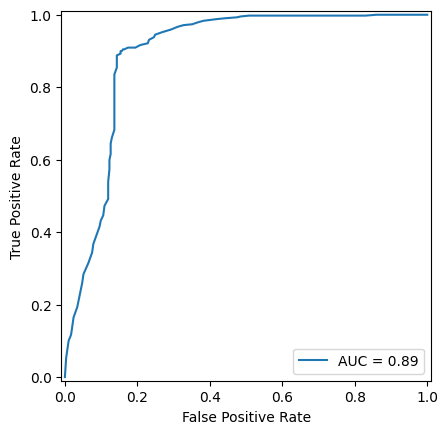

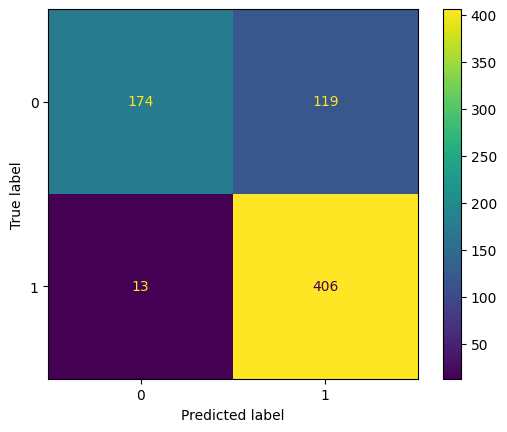

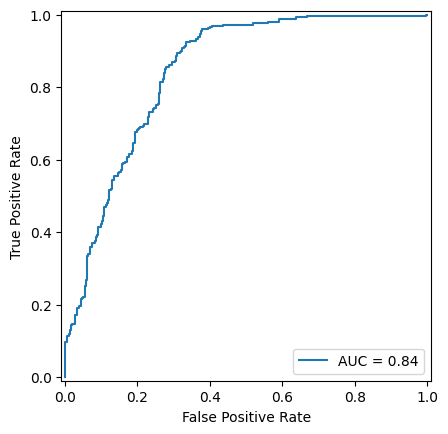

In [ ]:

for i, grid in enumerate(grid_list):
    print()
    print(grid.best_estimator_)
    best_model = grid.best_estimator_

    # Predictions
    preds = best_model.predict(Xs_test)
    accuracy = accuracy_score(ys_test, preds)
    cm = confusion_matrix(ys_test, preds)
    ConfusionMatrixDisplay(cm).plot()
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)

    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(Xs_test)[:, 1]
        print("ROC AUC:", roc_auc_score(ys_test, y_prob))
        
        fpr, tpr, thresholds = roc_curve(ys_test, y_prob)
        roc_auc = auc(fpr, tpr)

        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

    # df = pd.DataFrame({'Experimental Activity': ys_test, 'Predicted Activity': preds})

In [ ]:
## Apr. 21, 2025 -- Removed the repeating entries of Anc393, Anc509, Anc365, Anc366, Anc367
timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"/home/kaustubh/RuBisCO_ML/regressor_models/models/classifier_model/"

## Saving the best model
model_name = "RFC"
best_model = grid_list[2].best_estimator_
with open(f"{output_dir}/{model_name}_{timestamp_str}_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


## Loading the model
# with open(f"/home/kaustubh/RuBisCO_ML/regressor_models/models/classifier_model/{model_name}_best_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

## Analyze the results -- what constitute the false +ves & the False -ves

In [176]:
Xs_test_predict = best_model.predict(Xs_test)

incorrect_pred_ids = []
incorrect_pred_lsu = []
for i in range(len(Xs_test)):
    if Xs_test_predict[i] != ys_test[i]:
        incorrect_pred_ids.append(headers[test_indices[i]])
        incorrect_pred_lsu.append(headers[test_indices[i]].split("-")[0])
        # print(f"LSU_SSU_id: {headers[test_indices[i]]}")

/tmp/ipykernel_277363/3284462271.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='LSU_id', data=count_data, palette="pastel")


Text(0.5, 1.0, 'Count of Incorrect Predictions by LSU_id')

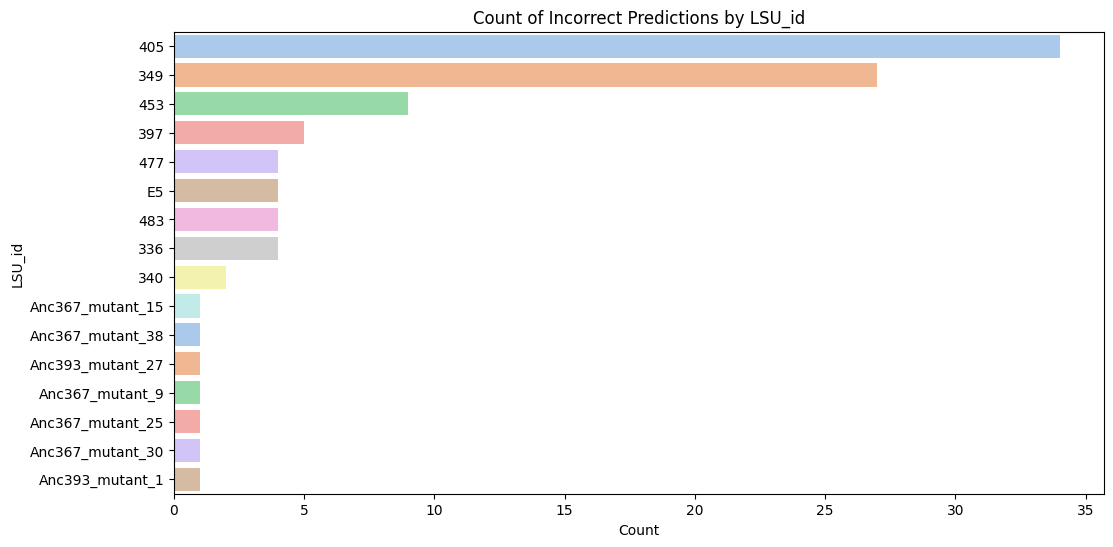

In [177]:
# Create a DataFrame from the incorrect predictions
incorrect_pred_df = pd.DataFrame({
    'LSU_SSU_id': incorrect_pred_ids,
    'LSU_id': incorrect_pred_lsu
})
# Count the occurrences of each LSU_id
count_data = incorrect_pred_df['LSU_id'].value_counts().reset_index()
count_data.columns = ['LSU_id', 'Count']
# Plot the count data
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='LSU_id', data=count_data, palette="pastel")
plt.title('Count of Incorrect Predictions by LSU_id')

In [178]:
len(ys_train), len(ys_test)

(2167, 712)

In [179]:
len([x for x in ys_train if x == 1]), len([x for x in ys_train if x == 0]), len([x for x in ys_test if x == 1]), len([x for x in ys_test if x == 0])

(1205, 962, 419, 293)

In [180]:
len(ys_test), len(Xs_test), len(test_ids)

(712, 712, 56)

## Training only on the large dataset & testing on the mutant dataset -- like the Rhodopsin paper

### Generating the corresponding Train & Test dataset

In [228]:
test_indices_divided = [i for i, x in enumerate(headers) if x.startswith("Anc")]
train_indices_divided = [i for i, x in enumerate(headers) if i not in test_indices_divided]

Xs_train_divide = [Xs[i] for i in train_indices_divided]
Xs_test_divide = [Xs[i] for i in test_indices_divided]
ys_train_divide = [ys[i] for i in train_indices_divided]
ys_test_divide = [ys[i] for i in test_indices_divided]

#### Checking if there are any common entries in the train and test set

In [231]:
[a1 for a1 in Xs_train_divide for a2 in ys_train_divide if np.array_equal(a1, a2)]

[]

### Training the model on the large dataset

In [ ]:
cls_list = [KNeighborsClassifier, SVC, RandomForestClassifier, LogisticRegression]
param_grid_list = [knn_grid, svc_grid, rfc_grid, lgr_grid]
result_list_divided = []
grid_list_divided = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(),
        param_grid = param_grid,
        scoring = 'accuracy',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train_divide, ys_train_divide)
    result_list_divided.append(pd.DataFrame.from_dict(grid.cv_results_))    
    grid_list_divided.append(grid)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


<class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 24 candidates, totalling 120 fits
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear

### Assessing the performance on the test mutant dataset

In [172]:
test_indices_divided = [i for i, x in enumerate(headers) if x.startswith("Anc3")]
# train_indices_divided = [i for i, x in enumerate(headers) if i not in test_indices_divided]

# Xs_train_divide = [Xs[i] for i in train_indices_divided]
Xs_test_divide = [Xs[i] for i in test_indices_divided]
# ys_train_divide = [ys[i] for i in train_indices_divided]
ys_test_divide = [ys[i] for i in test_indices_divided]


KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, p=1,
                     weights='distance')
Accuracy: 0.9651741293532339
Confusion Matrix:
 [[ 45   1]
 [  6 149]]
ROC AUC: 0.9927769985974754

SVC(C=10.0, kernel='linear')
Accuracy: 0.9651741293532339
Confusion Matrix:
 [[ 45   1]
 [  6 149]]

RandomForestClassifier(criterion='entropy')
Accuracy: 0.9651741293532339
Confusion Matrix:
 [[ 45   1]
 [  6 149]]
ROC AUC: 0.9927769985974754

LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=1000, penalty=None,
                   solver='saga')
Accuracy: 0.9651741293532339
Confusion Matrix:
 [[ 45   1]
 [  6 149]]
ROC AUC: 0.9927769985974754


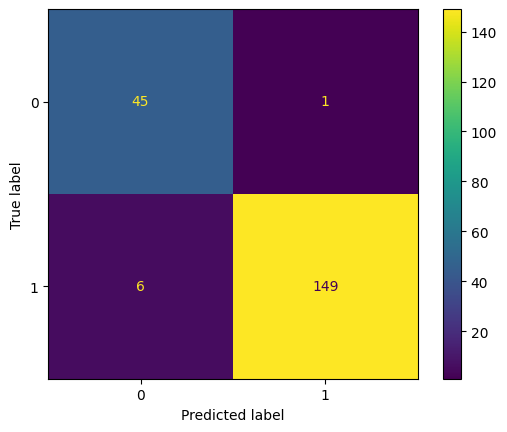

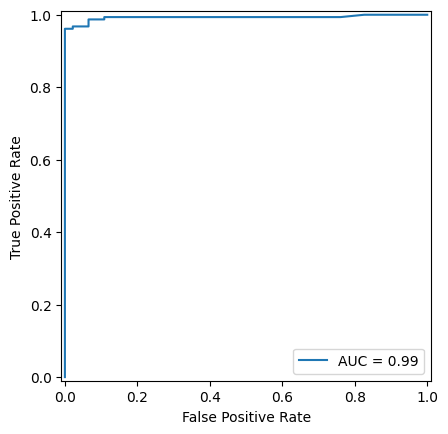

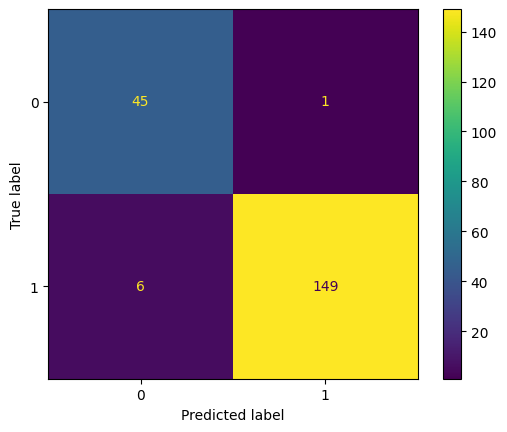

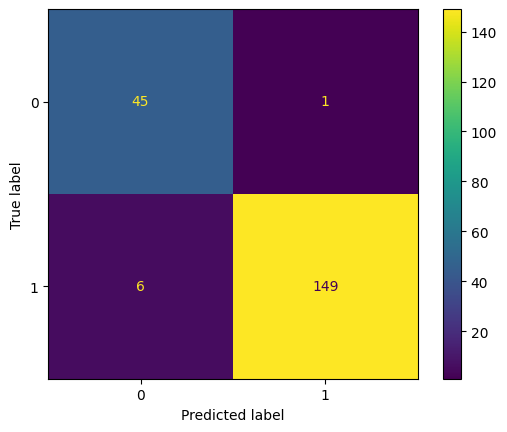

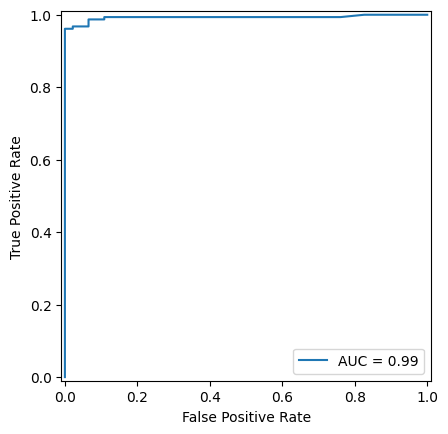

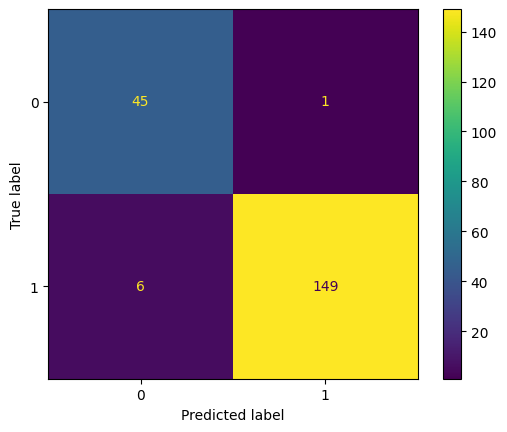

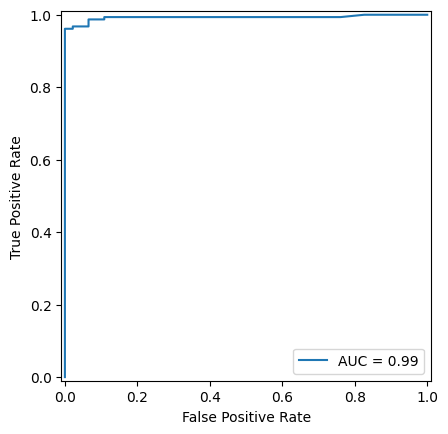

In [229]:
for i, grid in enumerate(grid_list_divided):
    print()
    print(grid.best_estimator_)
    best_model_divided = grid.best_estimator_

    # Predictions
    preds = best_model.predict(Xs_test_divide)
    accuracy = accuracy_score(ys_test_divide, preds)
    cm = confusion_matrix(ys_test_divide, preds)
    tn, fp, fn, tp = cm.ravel()
    ConfusionMatrixDisplay(cm).plot()
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)

    if hasattr(best_model_divided, "predict_proba"):
        y_prob = best_model.predict_proba(Xs_test_divide)[:, 1]
        print("ROC AUC:", roc_auc_score(ys_test_divide, y_prob))
        
        fpr, tpr, thresholds = roc_curve(ys_test_divide, y_prob)
        roc_auc = auc(fpr, tpr)

        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [174]:
grid_list_divided[0].best_estimator_, grid_list_divided[1].best_estimator_, grid_list_divided[2].best_estimator_, grid_list_divided[3].best_estimator_

(KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, p=1,
                      weights='distance'),
 SVC(C=10.0, kernel='linear'),
 RandomForestClassifier(criterion='entropy'),
 LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=1000, penalty=None,
                    solver='saga'))

In [175]:
## Apr. 22, 2025 (~ 11pm CST) -- Removed the repeating entries of Anc393, Anc509, Anc365, Anc366, Anc367 & large-small split for train-test (ls -lrt is Korean Time)

timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"/home/kaustubh/RuBisCO_ML/regressor_models/models/classifier_model/"

## Saving the best model
import pickle
model_name = "RFC"

best_model_divide = grid_list_divided[2].best_estimator_
with open(f"{output_dir}/{model_name}_{timestamp_str}_best_model_large_mutant_divide.pkl", "wb") as f:
    pickle.dump(best_model, f)

### Let's assess the inaccurate predictions

In [233]:
formIII_inaccurate_prediction_ids = []
for i in range(len(ys_test_divide)):
    if ys_test_divide[i] != preds[i]:
        formIII_inaccurate_prediction_ids.append(headers[test_indices_divided[i]])
        print(f"LSU_SSU_id: {headers[test_indices_divided[i]]}")
        print(f"label: {ys_test_divide[i]}; pred: {preds[i]}")
        print()

LSU_SSU_id: Anc367_mutant_15-none
label: 1; pred: 0

LSU_SSU_id: Anc367_mutant_38-none
label: 1; pred: 0

LSU_SSU_id: Anc393_mutant_27-none
label: 1; pred: 0

LSU_SSU_id: Anc367_mutant_9-none
label: 1; pred: 0

LSU_SSU_id: Anc367_mutant_25-none
label: 1; pred: 0

LSU_SSU_id: Anc367_mutant_30-none
label: 1; pred: 0

LSU_SSU_id: Anc393_mutant_1-none
label: 0; pred: 1



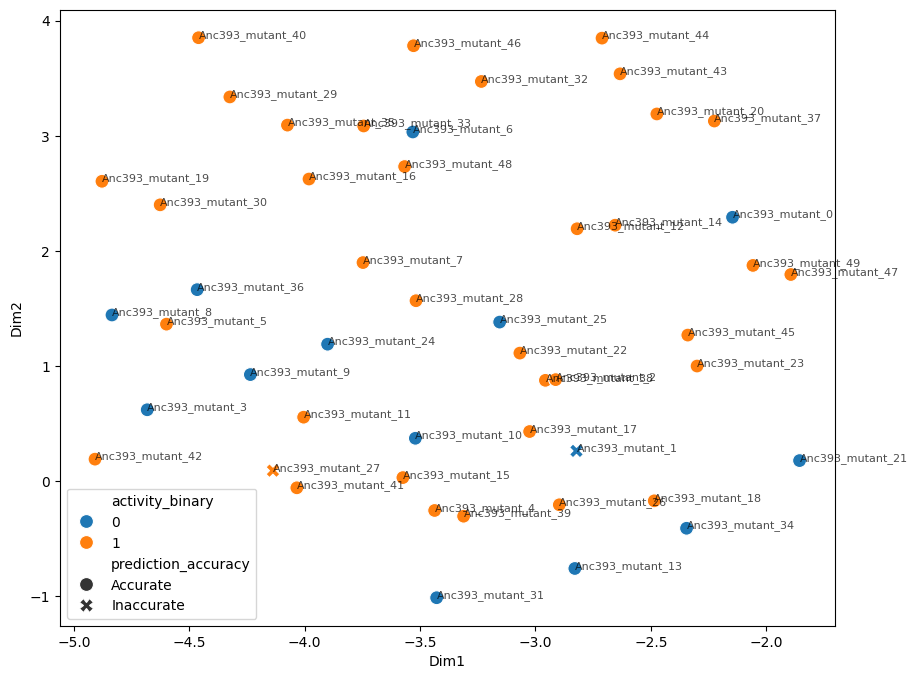

In [236]:
tsne_anc393_variants_df = make_tSNE(combined_dataset.query('LSU_id.str.startswith("Anc393") or LSU_id == "Anc365"'), "lsu_ssu_weighted_esm", "LSU_SSU_id", perplexity=30)
tsne_anc393_variants_df['prediction_accuracy'] = tsne_anc393_variants_df['LSU_SSU_id'].apply(lambda x: "Inaccurate" if x in formIII_inaccurate_prediction_ids else "Accurate")

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_anc393_variants_df, x="Dim1", y="Dim2", hue="activity_binary", style="prediction_accuracy", s=100)

for i in range(len(tsne_anc393_variants_df)):
    plt.annotate(tsne_anc393_variants_df['LSU_id'].iloc[i], (tsne_anc393_variants_df['Dim1'].iloc[i], tsne_anc393_variants_df['Dim2'].iloc[i]), fontsize=8, alpha=0.7)

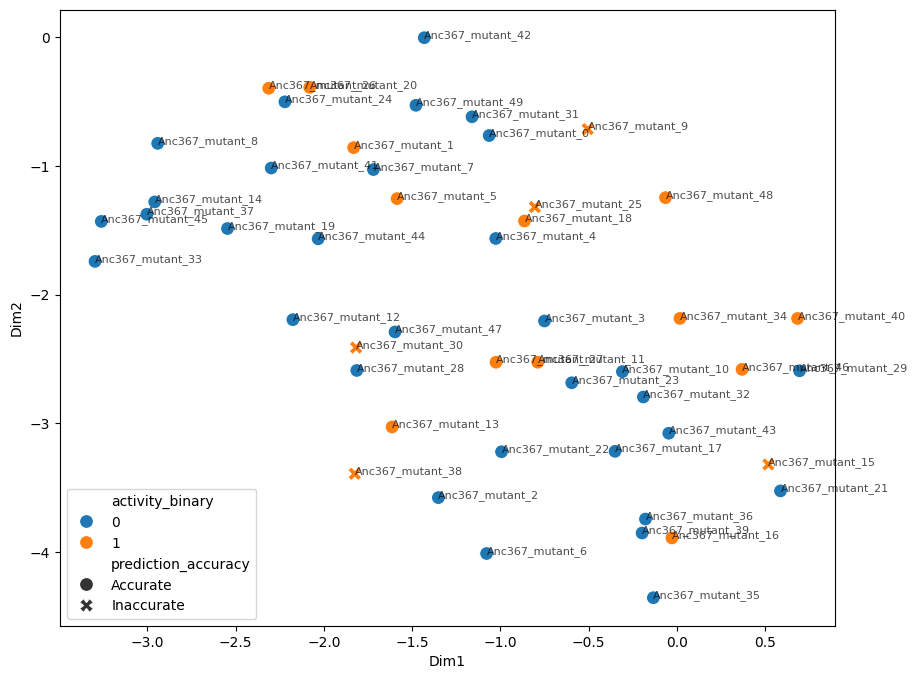

In [239]:
tsne_anc367_variants_df = make_tSNE(combined_dataset.query('LSU_id.str.startswith("Anc367") or LSU_id == "Anc366"'), "lsu_ssu_weighted_esm", "LSU_SSU_id", perplexity=30)
tsne_anc367_variants_df['prediction_accuracy'] = tsne_anc367_variants_df['LSU_SSU_id'].apply(lambda x: "Inaccurate" if x in formIII_inaccurate_prediction_ids else "Accurate")

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_anc367_variants_df, x="Dim1", y="Dim2", hue="activity_binary", style="prediction_accuracy", s=100)

for i in range(len(tsne_anc367_variants_df)):
    plt.annotate(tsne_anc367_variants_df['LSU_id'].iloc[i], (tsne_anc367_variants_df['Dim1'].iloc[i], tsne_anc367_variants_df['Dim2'].iloc[i]), fontsize=8, alpha=0.7)

## Mapping the sequence space for the sequences with experimental data from the `combined_dataset`

### Sequence space for the Large assay data

In [212]:
tsne_all_exp_seqs_df = make_tSNE(combined_dataset, "lsu_ssu_weighted_esm", 'LSU_SSU_id', perplexity=30)

tsne_all_exp_seqs_df['exp_dataset'] = tsne_all_exp_seqs_df.apply(
    lambda x: "Anc510 mutants" if x['LSU_id'].startswith("Anc510") 
    else "Anc 393 mutants" if x['LSU_id'].startswith("Anc393")
    else "Anc 367 mutants" if x['LSU_id'].startswith("Anc367")
    else "Large Assay", 
    axis=1)

In [213]:
tsne_all_exp_seqs_df

,LSU_id,SSU_id,lsu_seq,ssu_seq,activity_binary,LSU_SSU_id,LSU_SSU_seq,lsu_esm,ssu_esm,lsussu_esm,lsu_ssu_weighted_esm,Dim1,Dim2,exp_dataset
0,330,603,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQAYQQSQKTGTFSYLPPMTAEQVTAQIQYCLEKGWAICIEHTEPE...,0,330-603,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.014397109, 0.1016658, 0.0043634465, -0.0501...","[0.02668868, 0.030369857, -0.020122645, -0.062...","[0.036866662108974275, 0.024569500815891796, -...",6.230973,58.028767,Large Assay
1,330,605,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQATQQSSKTSSFSAAAERVLAQIGHCLRKGCVICIEHTPSMAPRF...,0,330-605,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.00887727, 0.0604165, 0.025597794, -0.042591...","[0.059421647, 0.018016538, -0.026957083, -0.07...","[0.03589694947004319, 0.015382249645962574, -0...",9.528922,57.081802,Large Assay
2,330,607,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQTTQATAATASFPAEERMLAQLGHCLRKGCVICIEHTAAMQPRYT...,0,330-607,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.009472309, 0.07615884, -0.0067444714, -0.03...","[0.036716472, 0.02174393, -0.027661683, -0.064...","[0.03607334572053145, 0.01854131440262473, -0....",8.319563,57.526882,Large Assay
3,330,E1,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MAEMQDYKQSLKYETFSYLPPMNAERIRAQIKYAIAQGWSPGIEHV...,0,330-E1,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.041855317, 0.06014329, 0.052978203, 0.03634...","[0.029892404, 0.022772918, -0.019961998, -0.05...","[0.04274496268115791, 0.01576483366536159, -0....",5.346647,58.791058,Large Assay
4,330,E2,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQVWPILNLKKYETLSYLPPLTTDQLARQVDYLLNNKWVPCLEFET...,0,330-E2,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.016487516, 0.10911158, 0.015158013, 0.05819...","[0.04928362, 0.015711864, -0.024561001, -0.059...","[0.03675680815546736, 0.028384373745886364, -0...",5.064991,58.557713,Large Assay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,Anc510_mutant_cluster_95,SSU_510,MQTQTQTKAGYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,Anc510_mutant_cluster_95-SSU_510,MQTQTQTKAGYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,"[0.011621203, 0.084631994, -0.018281156, -0.03...","[0.03639091, 0.08527323, 0.016811706, 0.012156...","[0.040780265, 0.06836804, -0.031451836, -0.024...","[0.015517160312566922, 0.08473285227411925, -0...",3.389702,-66.384468,Anc510 mutants
2875,Anc510_mutant_cluster_96,SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,Anc510_mutant_cluster_96-SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,"[0.00958667, 0.083476886, -0.0150982365, -0.03...","[0.03639091, 0.08527323, 0.016811706, 0.012156...","[0.04134488, 0.065365896, -0.030950816, -0.025...","[0.013808725793399132, 0.08375983604504537, -0...",3.496800,-62.991043,Anc510 mutants
2876,Anc510_mutant_cluster_97,SSU_510,MQTQTQTKAMYQAGVKDYRETYYTPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,Anc510_mutant_cluster_97-SSU_510,MQTQTQTKAMYQAGVKDYRETYYTPDYTPKDTDILAAFRVTPQPGV...,"[0.0100697605, 0.08149717, -0.014407573, -0.03...","[0.03639091, 0.08527323, 0.016811706, 0.012156...","[0.041152377, 0.06323463, -0.030103916, -0.024...","[0.01420377416976376, 0.0820902397464263, -0.0...",-0.815943,-63.557522,Anc510 mutants
2877,Anc510_mutant_cluster_98,SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,Anc510_mutant_cluster_98-SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,"[0.009374151, 0.08369483, -0.013429376, -0.033...","[0.03639091, 0.08527323, 0.016811706, 0.012156...","[0.041070905, 0.06535965, -0.028

(-80.0, 80.0)

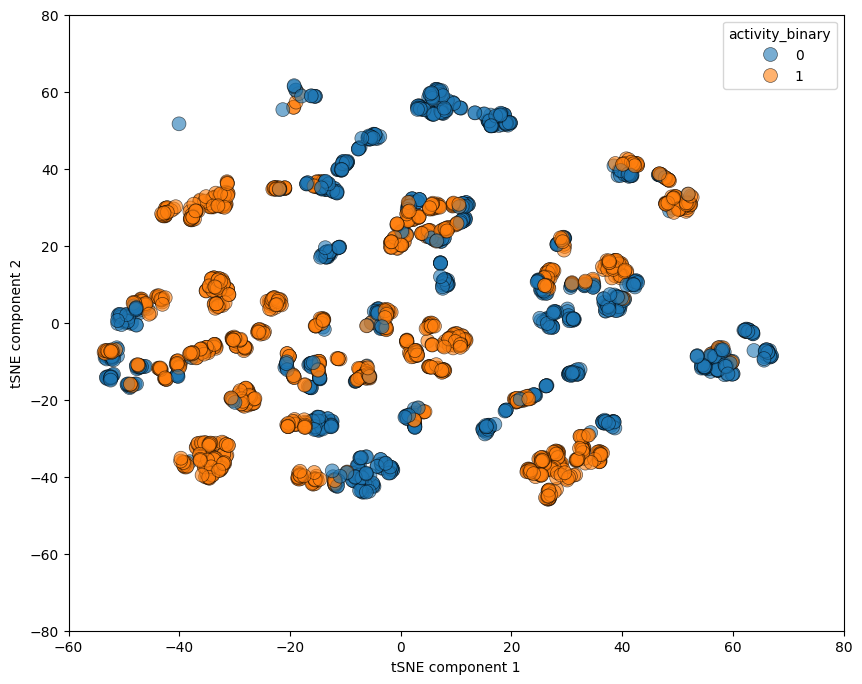

In [190]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_all_exp_seqs_df.query('~LSU_id.str.startswith("Anc")'), x="Dim1", y="Dim2", hue="activity_binary", alpha=0.6, s=100, edgecolor="black", linewidth=0.5)
plt.xlabel("tSNE component 1")
plt.ylabel("tSNE component 2")
plt.xlim(-60, 80)
plt.ylim(-80, 80)

### Sequence space for all data: Large assay + mutants

(-80.0, 80.0)

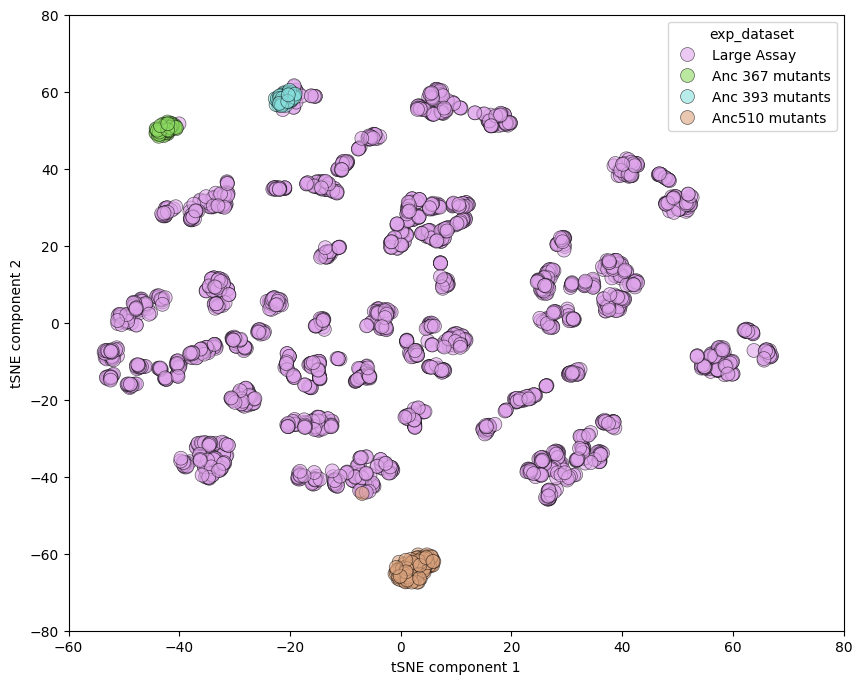

In [227]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_all_exp_seqs_df, x="Dim1", y="Dim2", hue="exp_dataset", palette={"Large Assay": "#DFA5EB", 'Anc 393 mutants': "#87E0DE", 'Anc510 mutants': "#DBA37D", 'Anc 367 mutants': "#8CDA61"}, alpha=0.6, s=100, edgecolor="black", linewidth=0.5)
plt.xlabel("tSNE component 1")
plt.ylabel("tSNE component 2")
plt.xlim(-60, 80)
plt.ylim(-80, 80)

(-80.0, 80.0)

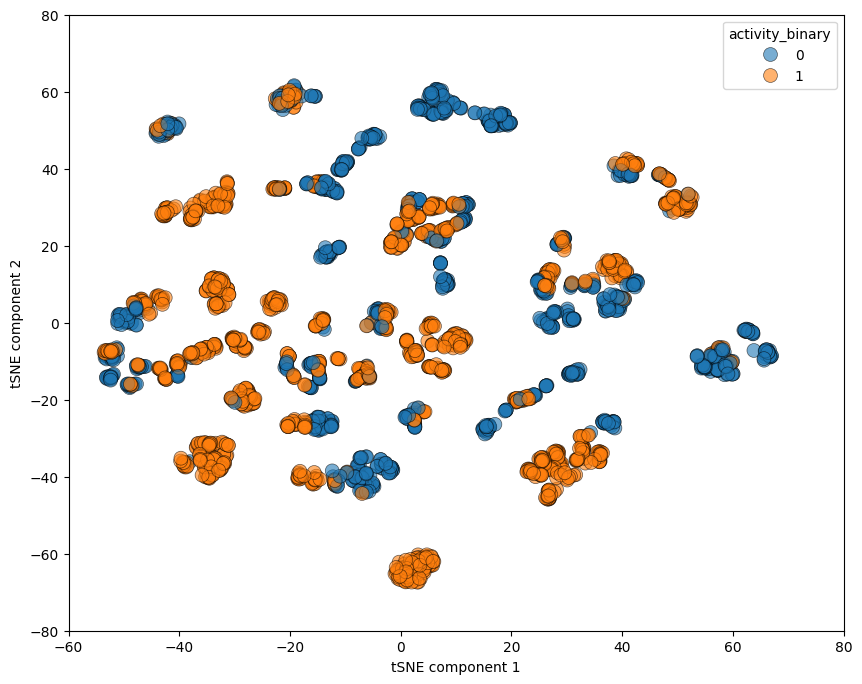

In [195]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_all_exp_seqs_df, x="Dim1", y="Dim2", hue="activity_binary", alpha=0.6, s=100, edgecolor="black", linewidth=0.5)
plt.xlabel("tSNE component 1")
plt.ylabel("tSNE component 2")
plt.xlim(-60, 80)
plt.ylim(-80, 80)

In [327]:
duplicated_seqs = tsne_all_exp_seqs_df[tsne_all_exp_seqs_df.duplicated('LSU_SSU_seq', keep=False)]
duplicated_seqs.sort_values('LSU_SSU_id')

,LSU_id,SSU_id,lsu_seq,ssu_seq,activity_binary,LSU_SSU_id,LSU_SSU_seq,lsu_esm,ssu_esm,lsussu_esm,lsu_ssu_weighted_esm,Dim1,Dim2,exp_dataset
1817,330,435,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,0,330-435,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.045341305, 0.020503858, -0.02762157, -0.078...","[0.04032798531273055, 0.021615917350919472, -0...",5.641923,59.418903,Large Assay
1822,330,494,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,0,330-494,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.042989615, 0.0035607587, -0.019734478, -0.0...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.045341305, 0.020503858, -0.02762157, -0.078...","[0.04032798531273055, 0.021615917350919472, -0...",5.641922,59.418903,Large Assay
7,331,435,MAENDLIATYHIEDGVDLEKAAQEIAAEQSTGTWTDVSTEQELVEK...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,0,331-435,MAENDLIATYHIEDGVDLEKAAQEIAAEQSTGTWTDVSTEQELVEK...,"[0.03672988, 0.0073545706, -0.007477744, -0.03...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.040499512, 0.025427219, -0.0158097, -0.0431...","[0.03535994112728134, 0.02462687916935436, -0....",19.613010,51.921688,Large Assay
2069,331,494,MAENDLIATYHIEDGVDLEKAAQEIAAEQSTGTWTDVSTEQELVEK...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,0,331-494,MAENDLIATYHIEDGVDLEKAAQEIAAEQSTGTWTDVSTEQELVEK...,"[0.03672988, 0.0073545706, -0.007477744, -0.03...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.040499512, 0.025427219, -0.0158097, -0.0431...","[0.03535994112728134, 0.02462687916935436, -0....",19.613010,51.921688,Large Assay
205,332,435,MADKDVIATYHIEEGVTLEKAAQEIAAEQSTGTWTDVSTEQEVVEK...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,0,332-435,MADKDVIATYHIEEGVTLEKAAQEIAAEQSTGTWTDVSTEQEVVEK...,"[0.03687397, -0.007435782, -0.009279005, -0.04...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.03861182, 0.014170787, -0.018721003, -0.048...","[0.03547429866970531, 0.01288850422179888, -0....",18.562737,53.859356,Large Assay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,E6,494,MAIHNPLAGPKTVKARPTAELSDAYKAGVRAYAVDYYVPDYIPQDT...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,1,E6-494,MAIHNPLAGPKTVKARPTAELSDAYKAGVRAYAVDYYVPDYIPQDT...,"[0.008005398, 0.06350599, -0.005292411, -0.003...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.0134494025, 0.073227026, -0.0040079867, -0....","[0.012056363107574155, 0.06855977656454426, -0...",7.730560,-12.245766,Large Assay
1587,E7,435,MHEHFDSIYLEFVDESYKPGKDEVIAVFRVTPAQGISIKDAAGRIA...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,1,E7-435,MHEHFDSIYLEFVDESYKPGKDEVIAVFRVTPAQGISIKDAAGRIA...,"[0.06999855, 0.02175074, -0.032208003, -0.0593...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.06400008, 0.026238874, -0.02982572, -0.0599...","[0.06238315206602079, 0.034976505563346624, -0...",-37.898148,26.946213,Large Assay
2149,E7,494,MHEHFDSIYLEFVDESYKPGKDEVIAVFRVTPAQGISIKDAAGRIA...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,1,E7-494,MHEHFDSIYLEFVDESYKPGKDEVIAVFRVTPAQGISIKDAAGRIA...,"[0.06999855, 0.02175074, -0.032208003, -0.0593...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.06400008, 0.026238874, -0.02982572, -0.0599...","[0.06238315206602079, 0.034976505563346624, -0...",-37.898148,26.946213,Large Assay
2053,E8,435,MIQEELSKTLNPKQVQYMRMDLPDPRNGEYLLAVFHLIPSGELNIM...,MSMRLETFSYLPPLSDEQIRKQIQYILNQGWVPAIEYTERPDPRDH...,1,E8-435,MIQEELSKTLNPKQVQYMRMDLPDPRNGEYLLAVFHLIPSGELNIM...,"[0.011285798, 0.06260233, -0.0038658367, -0.01...","[0.030090947, 0.091058835, 0.019819036, -0.045...","[0.013355462, 0.07155554, -0.005782469, -0.027...","[0.014663579207820904, 0.06771369153611195, 0....",23.239075,-38.215405,Large Assay
